## Exercise 9

**Tip** This is a very small dataset (number of observations) compared to the number of features.
This means that overfitting may be an issue, and sometimes fancy tricks won't do any good. 
Keep that in mind, and always start simple.

**3.1) Improve the network**, and get as high a validation score as you can. 
When trying to improve the network nothing is sacred. You can try various learning rates, batch sizes, validation sizes, etc. 
And most importantly, the validation set is very small (only 1 sample per class), etc.

To get you off to a good start we have created a list of **things you might want to try**:
* Add more layers (mostly fully connected and convolutional)
* Increase or decrease the batch size 
* Use dropout (a lot - e.g. between the convolutional layers)
* Use batch normalization (a lot)
* Try with L2 regularization (weight decay)
* Use only the image for training (with CNN) - comment on the increased time between iterations.
* Change the image size to be bigger or smaller
* Try other combinations of FFN, CNN, RNN parts in various ways (bigger is not always better)

If your network is not performing as well as you would like it to, [here](http://theorangeduck.com/page/neural-network-not-working) is a great explanation of what might have gone wrong.


**3.2) Improve Kaggle score**. Once happy try to get the best score on Kaggle for this dataset as you can (**upload** instructions below)
You can upload your solution multiple times as you progress.
A very good implementation would get a score between $0.04$ to $0.06$ (the smaller the better), try and see if you can get there, and explain what might have gone wrong if you can't. 


**3.3) Reflect on the process**, and how you got to your final design and discuss your final results. 
What worked, and what didn't?
Include at least the following: 
* Description of the final architecture
* Description of the training parameters
* Description of the final results (Kaggle and validation)

**Answer:**


# Move to the directory

In [1]:
cd ~/Documents/dl/LeafClassification

/zhome/68/a/154632/Documents/dl/LeafClassification


In [2]:
ls

6_1_EXE_Kaggle_Leaf_Challenge.ipynb  Submission.ipynb  pickles/
NN.ipynb                             __pycache__/      sample_submission.csv
NN_1.ipynb                           data_utils.py     test.csv
Preprocessing.ipynb                  images/           train.csv
README.md                            my_process.md


# Libraries

In [3]:
%matplotlib inline
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import time
import copy

from IPython.display import clear_output
from skimage.io import imread
from skimage.transform import resize

import data_utils

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear, GRU, Conv2d, Dropout, MaxPool2d, BatchNorm1d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax
from skimage import io
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Check if CUDA device is available

In [4]:
use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x


def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

Running GPU.


# Load data

In [5]:
import pickle
with open('pickles/data.pickle', 'rb') as f:
    data = pickle.load(f)

# Utils

In [6]:
class SelectItem(nn.Module):
    def __init__(self, item_index):
        super(SelectItem, self).__init__()
        self._name = 'selectitem'
        self.item_index = item_index

    def forward(self, inputs):
        return inputs[self.item_index]

In [7]:
def conv_size(img_size, kernel_size, stride, padding, channels):
    W = img_size
    K = kernel_size
    P = padding
    S = stride

    output_size = int((W-K+(2*P))/S)+1

    return (output_size, output_size, channels)

In [8]:
def pool_size(img_size, kernel_size, stride, channels):
    I = img_size
    F = kernel_size
    S = stride

    output_size = (((I - F) / S) + 1)
    
    return (output_size, output_size, channels)

In [9]:
print(conv_size(128, 3, 2, 1, 8))
print(pool_size(64, 2, 2, 8))

(64, 64, 8)
(32.0, 32.0, 8)


# Parameters

In [10]:
IMAGE_SHAPE = (128, 128, 1)
NUM_CLASSES =  99
batch_size = 32
# For all three features types margin, shape, and texture, we have NUM_FEATURES for each type.
NUM_FEATURES = 64  # <-- Your answer here

# Advanced Model

## Print some info on the dataset

In [11]:
leafs_frame = pd.read_csv('train.csv')

n = 65
row = leafs_frame.iloc[n, :]
id = leafs_frame.iloc[n, 0]
img_name = str(id) + '.jpg'
species = leafs_frame.iloc[n, 1]
margins = leafs_frame.iloc[n, 2:66]
shapes = leafs_frame.iloc[n, 66:130]
textures = leafs_frame.iloc[n, 130:]

print(f'Row shape: {row.shape}')
print(f'ID: {id}')
print(f'Species: {species}')
print(f'Margins\' shape: {margins.shape}')
print(f'Shapes\' shape: {shapes.shape}')
print(f'Textures\' shape: {textures.shape}')

Row shape: (194,)
ID: 109
Species: Quercus_Texana
Margins' shape: (64,)
Shapes' shape: (64,)
Textures' shape: (64,)


## Data Loader

In [50]:
class LeafDataset(Dataset):
    """Leaf dataset."""

    def __init__(self, csv_file, root_dir, transform=None, train=False, test=False):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.leafs_df = pd.read_csv(csv_file)
        self.data = self.leafs_df.values
        self.root_dir = root_dir
        self.transform = transform
        self.train = train
        self.test = test

        self.parse_data()

    def parse_data(self):
        self.ids = np.array(self.data[:, 0], dtype=int)
        if self.train:
            self.labels = pd.Categorical(pd.factorize(self.leafs_df.species)[0])
            self.labels = np.array(self.labels)
            self.label_dummies = pd.get_dummies(self.leafs_df.species)
            self.label_dummies = np.array(self.label_dummies)
            self.species = np.array(self.data[:, 1], dtype=str)
            self.margins = np.array(self.data[:, 2:66], dtype=float)
            self.shapes = np.array(self.data[:, 66:130], dtype=float)
            self.textures = np.array(self.data[:, 130:], dtype=float)
        if self.test:
            self.labels = np.empty((len(self.data), 1), dtype=int)
            self.label_dummies = np.empty((len(self.data), NUM_CLASSES), dtype=int)
            self.species = np.empty((len(self.data)), dtype=str)
            self.margins = np.array(self.data[:, 1:65], dtype=float)
            self.shapes = np.array(self.data[:, 65:129], dtype=float)
            self.textures = np.array(self.data[:, 129:], dtype=float)


    def __len__(self):
        return len(self.leafs_df)

    def __getitem__(self, idx):
        # get the image
        img_name = str(self.ids[idx]) + '.jpg'
        img_path = os.path.join(self.root_dir, img_name)
        image = io.imread(img_path)

        # no matter what happens, we need to padd all the images to the same dimensions, so that we can resize them without distorting them
        image = data_utils.pad2square(image)  # Make the image square
        image = resize(image, output_shape=(128, 128), mode='reflect', anti_aliasing=True)  # resizes the image

        # augment the image if chosen to
        if self.transform:
            image = self.transform(image)

        # get the other data
        margin = self.margins[idx]
        shape = self.shapes[idx]
        texture = self.textures[idx]
        label = self.labels[idx]
        label_dummy = self.label_dummies[idx]
        specie = self.species[idx]
            
        return image, margin, shape, texture, label, label_dummy, specie

## Load trainset and testset using the Dataloader

In [51]:
train_transform = transforms.Compose([transforms.ToTensor()])
val_transform = transforms.Compose([transforms.ToTensor()])
train_csv = 'train.csv'
test_csv = 'test.csv'
root_dir = 'images/'

batch_size = 32
trainset = LeafDataset(train_csv, root_dir, transform=train_transform, train=True, test=False)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
testset = LeafDataset(test_csv, root_dir, transform=train_transform, train=False, test=True)
val_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

## Plot function

In [52]:
def show_leafs(image, margin, shape, texture, label=None, species=None):
    """Show image and margin"""
    # Convert 3d image to 2d
    img_shape = image.shape
    image = image.numpy().reshape(img_shape[1], img_shape[2])
    
    fig = plt.figure(figsize=(20,3))
    ax1 = fig.add_subplot(141)
    ax1.imshow(image)
    ax2 = fig.add_subplot(142)
    ax2.plot(margins)
    ax3 = fig.add_subplot(143)
    ax3.plot(shapes)
    ax4 = fig.add_subplot(144)
    ax4.plot(textures)
    plt.suptitle(f"species: {species}")
    plt.pause(0.001)  # pause a bit so that plots are updated
    plt.show()

## Test dataloader and plot function

0 torch.Size([1, 128, 128]) (64,) (64,) (64,)
sample #0


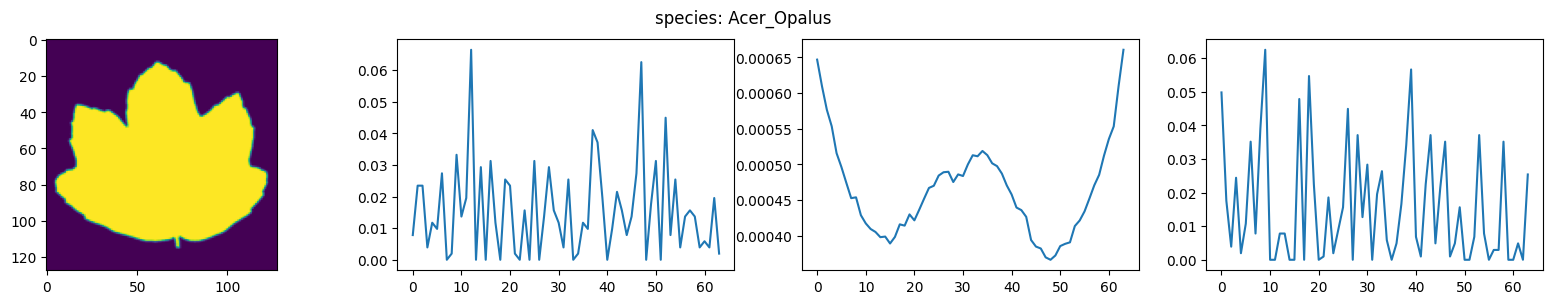

In [53]:
for i in range(len(trainset)):
    data = trainset[i]
    image, margins, shapes, textures, label, label_dummy, species = data
    
    print(i, image.shape, margins.shape, shapes.shape, textures.shape)

    print(f'sample #{i}')
    show_leafs(image, margins, shapes, textures, label, species)

    if i == 0:
        break

## Network

In [54]:
# The image shape should be of the format (height, width, channels)
IMAGE_SHAPE = (128, 128, 1)   # <-- Your answer here
NUM_CLASSES =  99  # <-- Your answer here 

# For all three features types margin, shape, and texture, we have NUM_FEATURES for each type.
NUM_FEATURES = 64  # <-- Your answer here

In [55]:
height, width, channels = IMAGE_SHAPE
batch_size = 32

# Keep track of features to output layer
features_cat_size = 1024 # <-- Number of features concatenated before output layer

rnn_input_size = 64 # must be the same as the x_shape channels

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.convolutional = nn.Sequential(
            nn.Conv2d(in_channels = 1,
                    out_channels = 8,
                    kernel_size = (3, 3),
                    stride = 2,
                    padding = 1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, 
                         stride = 2),
            nn.Dropout(0.2)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(in_features=32*32*8,
                    out_features=768,
                    bias=False),
            nn.Dropout(0.5)
        )

        self.fc2 = nn.Sequential(
            nn.Linear(in_features=128,
                    out_features=128,
                    bias=False),
            nn.Dropout(0.5)
        )

        # Exercise: Add a recurrent unit like and RNN or GRU
        # >> YOUR CODE HERE <<
        self.recurrent = nn.Sequential(
            nn.GRU(input_size=rnn_input_size, # The number of expected features in the input x
                    hidden_size=128, # The number of features in the hidden state h
                    num_layers=2), # Number of recurrent layers
            SelectItem(0)
        )

        self.l_out = nn.Sequential(
            nn.Linear(in_features=features_cat_size,
                        out_features=NUM_CLASSES,
                        bias=False)
        )
        self.softmax = nn.Softmax(dim=1)
        
        
    def forward(self, X):
        X_img, x_margin, x_shape, x_texture = X
        # for _ in X:
        #     print(f"Device: {_.get_device()}")
        features = []

        # Change layer order in images
        X_img = X_img.float()
        # X_img = X_img.permute(3, 2, 1)
        
        ## Convolutional layer ##
        # - Change dimensions to fit the convolutional layer 
        # - Apply Conv2d
        # - Use an activation function
        # - Change dimensions s.t. the features can be used in the final FFNN output layer
        
        # >> YOUR CODE HERE <<
        ## 1st way, distort image
        # print("Convolutional...")
        # print(x_img.shape)
        X_img = self.convolutional(X_img)
        # print(x_img.shape)
        X_img = X_img.reshape(X_img.size(0), -1)
        # print(x_img.shape)
        features_img = self.fc1(X_img)
        # print(features_img.shape)

        # Append features to the list "features"
        features.append(features_img)
        
        ## Use concatenated leaf features for FFNN ##
        # print("\nFeed Forward...")
        # print(x_margin.shape, x_texture.shape)
        x = torch.cat((x_margin, x_texture), dim=1)  # if you want to use features as feature vectors
        # print(x.shape)
        x = self.fc2(x)
        features_vector = x
        # print(features_vector.shape)
        
        ## Use concatenated leaf features for RNN ##
        # - Chage dimensions to fit GRU
        # - Apply GRU
        # - Change dimensions s.t. the features can be used in the final FFNN output layer

        # >> YOUR CODE HERE <<
        # print("\nRecurrent...")
        # print(x_shape.shape)
        features_rnn = self.recurrent(x_shape)
        features.append(features_rnn)
        # print(features_rnn.shape)
        
        # Append features to the list "features"
        features.append(features_rnn)
        
        ## Output layer where all features are in use ##
        # print("\Features...")
        features_final = torch.cat(features, dim=1)
        # print(features_final.shape)
        
        # print("\nOutput...")
        out = self.l_out(features_final)
        out_prob = self.softmax(out)
        # print(out.shape, out_prob.shape)
       
        return out, out_prob

net = Net()
net = net.float()
if use_cuda:
    net.to(device)
print(net)

Net(
  (convolutional): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.2, inplace=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=8192, out_features=768, bias=False)
    (1): Dropout(p=0.5, inplace=False)
  )
  (fc2): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=False)
    (1): Dropout(p=0.5, inplace=False)
  )
  (recurrent): Sequential(
    (0): GRU(64, 128, num_layers=2)
    (1): SelectItem()
  )
  (l_out): Sequential(
    (0): Linear(in_features=1024, out_features=99, bias=False)
  )
  (softmax): Softmax(dim=1)
)


## Test network

In [58]:
for data in train_loader:
    # convert everything to cuda tensor on device 0
    image, margins, shapes, textures, labels, label_dummies, specie = data
    species = np.array(species)
    
    image = image.to(device).float()
    margins = margins.to(device).float()
    shapes = shapes.to(device).float()
    textures = textures.to(device).float()

    inputs = image, margins, shapes, textures

    break

net.train()
output, output_prob = net(inputs)
print(f"Shape: {output.shape}, Output{output}")
print(f"Shape: {output_prob.shape}, Output: {output_prob}")

Shape: torch.Size([32, 99]), Outputtensor([[ 0.4838,  0.4405, -0.2084,  ..., -0.5555,  0.4346, -0.1643],
        [ 0.2333,  0.8621,  0.3614,  ..., -0.3841, -0.0864,  0.0292],
        [ 0.6014, -0.1383,  0.2913,  ..., -0.2214,  0.2848, -0.2547],
        ...,
        [-0.0230,  0.0468,  0.1966,  ..., -0.1215, -0.4200,  0.1603],
        [ 0.4575,  0.3185,  0.4765,  ...,  0.0242, -0.4928,  0.1123],
        [-0.8297,  0.4074, -0.2840,  ..., -0.1010, -0.3729,  0.2434]],
       device='cuda:0', grad_fn=<MmBackward0>)
Shape: torch.Size([32, 99]), Output: tensor([[0.0148, 0.0142, 0.0074,  ..., 0.0052, 0.0141, 0.0077],
        [0.0120, 0.0226, 0.0137,  ..., 0.0065, 0.0088, 0.0098],
        [0.0181, 0.0086, 0.0132,  ..., 0.0079, 0.0132, 0.0077],
        ...,
        [0.0096, 0.0103, 0.0119,  ..., 0.0087, 0.0064, 0.0115],
        [0.0160, 0.0139, 0.0163,  ..., 0.0104, 0.0062, 0.0113],
        [0.0041, 0.0141, 0.0071,  ..., 0.0085, 0.0065, 0.0120]],
       device='cuda:0', grad_fn=<SoftmaxBackward0

## Train function

In [59]:
a = torch.randn(2, 4)
print(a)
torch.max(a, 1)

tensor([[ 1.9005, -1.5261, -0.6411,  0.5832],
        [ 1.6582,  1.3138,  0.9418, -1.0132]])


torch.return_types.max(
values=tensor([1.9005, 1.6582]),
indices=tensor([0, 0]))

In [83]:
def train(model, opt, loss_fn, epochs, train_loader, val_loader):
    epoch_results = []
    for epoch in range(epochs):
        print(f"Epoch #{epoch}")

        train_loss = 0
        train_correct = 0
        model.train()  # train mode
        for data in train_loader:
            # extract subfields
            image, margins, shapes, textures, labels, label_dummies, species = data
            
            # convert to float and move to cuda
            image = image.to(device).float()
            margins = margins.to(device).float()
            shapes = shapes.to(device).float()
            textures = textures.to(device).float()

            # split input and label
            inputs = image, margins, shapes, textures
            labels = labels.to(device).float()
            label_dummies = label_dummies.to(device).float()

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            output, y_prob = model(inputs)
            (y_prob_max, y_pred) = torch.max(y_prob, 1)
            
            # print(f"Output: {output}")
            # print(f"label_dummies: {label_dummies}")
            # print(f"Predicted: {y_pred}")
            # print(f"Labels: {labels}")
            
            # calculate loss function
            loss = loss_fn(label_dummies, y_prob)
            # back-propagation
            loss.backward()
            # weight update
            opt.step()

            # calculate metrics to show the user
            train_correct += (labels == y_pred).sum().cpu().item()
            train_loss += loss / len(train_loader)
            
        #print(' - accuracy: %f' % train_accuracy)
        train_accuracy = train_correct/(len(trainset)*128*128)
        print(' - train accuracy: %f' % train_accuracy)
        print(' - train loss: %f' % train_loss)

        # show intermediate results
        # Compute the val accuracy
        model.eval()  # testing mode
        val_correct = 0
        val_loss = 0
        with torch.no_grad():
            for data in val_loader:
                # extract subfields
                image, margins, shapes, textures, labels, label_dummies, species = data
                
                # convert to float and move to cuda
                image = image.to(device).float()
                margins = margins.to(device).float()
                shapes = shapes.to(device).float()
                textures = textures.to(device).float()

                # split input and label
                inputs = image, margins, shapes, textures
                labels = labels.to(device).float()
                label_dummies = label_dummies.to(device).float()

                output, y_prob = model(inputs)
                (y_prob_max, y_pred) = torch.max(y_prob, 1)

                loss = loss_fn(label_dummies, y_prob)
                val_loss += loss/len(val_loader)
                val_correct += (labels==y_pred).sum().cpu().item()

        print(' - val loss: %f' % val_loss)
        val_accuracy = val_correct/(len(testset)*128*128)
        print(' - val accuracy: %f' % val_accuracy)
        print("\n")

        epoch_results.append([train_accuracy, train_loss.item(), val_accuracy, val_loss.item()])
    
    return epoch_results

## Train parameters

In [84]:
LEARNING_RATE = 0.001
num_epochs = 3
criterion = criterion = nn.CrossEntropyLoss()

# weight_decay is equal to L2 regularization
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE) # , momentum=0.9)

def accuracy(ys, ts):
    predictions = torch.max(ys, 1)[1]
    correct_prediction = torch.eq(predictions, ts)
    return torch.mean(correct_prediction.float())

## Train the network

In [85]:
results = train(net, optimizer, criterion, num_epochs, train_loader, val_loader)

Epoch #0
 - train accuracy: 0.000001
 - train loss: 4.602245
 - val loss: 303117797951537152.000000
 - val accuracy: 0.000000


Epoch #1
 - train accuracy: 0.000001
 - train loss: 4.602245
 - val loss: 303117797951537152.000000
 - val accuracy: 0.000000


Epoch #2
 - train accuracy: 0.000001
 - train loss: 4.602178
 - val loss: 303117797951537152.000000
 - val accuracy: 0.000000




## Plot results

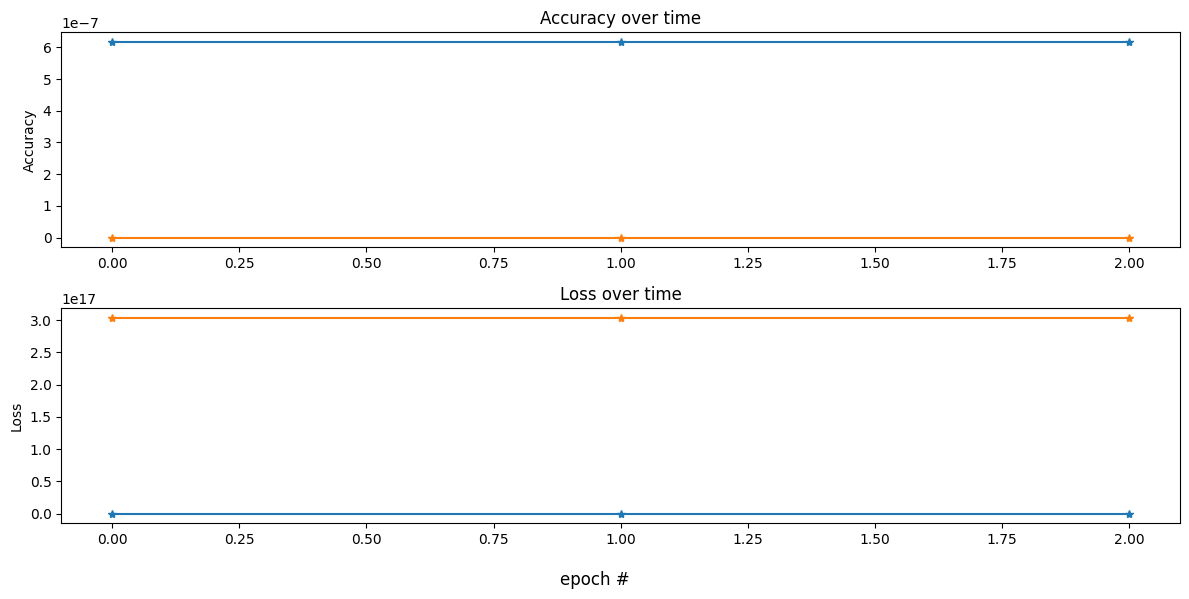

In [100]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12,6))

ax1.plot(np.arange(len(results)), np.array(results)[:,0], "-*", label="train_acc")
ax1.plot(np.arange(len(results)), np.array(results)[:,2], "-*", label="val_acc")
ax2.plot(np.arange(len(results)), np.array(results)[:,1], "-*", label="train_loss")
ax2.plot(np.arange(len(results)), np.array(results)[:,3], "-*", label="val_loss")

fig.set_tight_layout(0.2)
fig.supxlabel("epoch #")

ax1.set_title("Accuracy over time")
ax1.set_ylabel("Accuracy")
ax2.set_ylabel("Loss")
ax2.set_title("Loss over time")

plt.show()